In [198]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [199]:
df = pd.read_csv("../data/adm_data.csv", index_col=[0])
X = df.drop(["Chance of Admit "], axis=1)
y = df[["Chance of Admit "]]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [181]:
class SOM:
    def __init__(self, nx: int, ny: int, learning_rate=0.1, neighborhood_radius=0.1, decay_ratio=1.001, tol=1e-4, max_iter=500, random_state=0):
        self.__nx = nx
        self.__ny = ny
        self.__learning_rate = learning_rate
        self.__neighborhood_radius = neighborhood_radius
        self.__decay_ratio = decay_ratio
        self.__max_iter = max_iter
        self.__random_state = random_state
        self.__fitted = False
        self.__features = []
        self.__coordinates_cols = ["x", "y"]
        x = np.arange(0, self.__nx, 1)
        y = np.arange(0, self.__ny, 1)
        xv, yv = np.meshgrid(x, y)
        coordinates = np.column_stack([xv.flatten(), yv.flatten()])
        self.map = pd.DataFrame(coordinates, columns=self.__coordinates_cols)
    
    def fit(self, X: pd.DataFrame):
        self.__features = list(X.columns)
        self.__init_neurons(X)
        iter_count = 0
        while True:
            rand = np.random.RandomState(self.__random_state)
            index = rand.choice(list(X.index), 1)
            point = X.loc[index].values
            weights = self.map[self.__features]
            distances = np.linalg.norm(weights.values - point, axis=1)
            best_matching_unit = np.argmin(distances)
            self.__update_neurons(point, best_matching_unit)
            self.__update_hyperparameters()
            self.__random_state += 1
            iter_count += 1
            if np.allclose(self.map[self.__features], weights) or iter_count >= self.__max_iter:
                self.__fitted = True
                return self
            
    def predict(self, X: pd.DataFrame):
        assert self.__fitted == True
        predictions = np.empty(X.shape[0], dtype=int)
        for i, point in enumerate(X.values):
            weights = self.map[self.__features]
            distances = np.linalg.norm(weights.values - point, axis=1)
            predictions[i] = np.argmin(distances)
        return predictions
    
    def __init_neurons(self, X: pd.DataFrame):
        rand = np.random.RandomState(self.__random_state)
        neurons = X.loc[rand.choice(X.index, size=len(self.map), replace=False)].reset_index(drop=True)
        self.map = pd.concat([self.map, neurons], axis=1)
        return self.map
    
    def __update_neurons(self, point: np.array, best_matching_unit: int):
        for neuron in self.map.index:
            neuron_weight = self.map.loc[neuron, self.__features]
            neighborhood_func = self.__gaussian_neighborhood_function(neuron, best_matching_unit)
            point_neuron_difference = point.flatten() - neuron_weight.values
            self.map.loc[neuron, self.__features] = neuron_weight + neighborhood_func * self.__learning_rate * point_neuron_difference
    
    def __update_hyperparameters(self):
        self.__learning_rate = self.__learning_rate/self.__decay_ratio
        self.__neighborhood_radius  = self.__neighborhood_radius/self.__decay_ratio
    
    def __gaussian_neighborhood_function(self, neuron: int, best_matching_unit: int):
        neuron_xy = self.map.loc[neuron, self.__coordinates_cols].values
        bmu_xy = self.map.loc[best_matching_unit, self.__coordinates_cols].values
        distance = np.linalg.norm(neuron_xy - bmu_xy)
        return np.exp(-distance/(2*self.__neighborhood_radius**2))
        

In [189]:
som = SOM(nx=5, ny=2, learning_rate=0.1, neighborhood_radius=1, tol=0.0001, max_iter=500, random_state=0)
som.fit(X)

C:\Users\Samsung\AppData\Local\Temp\ipykernel_9544\3826417771.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.2' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  self.map.loc[neuron, self.__features] = neuron_weight + neighborhood_func * self.__learning_rate * point_neuron_difference


In [192]:
neurons = som.predict(X)
X_with_neuron = X.copy()
X_with_neuron["neuron"] = neurons

In [208]:
pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=["pca1", "pca2"], index=X.index)
X_pca_with_neuron = X_pca.copy()
X_pca_with_neuron["neuron"] = neurons

<Axes: xlabel='pca1', ylabel='pca2'>

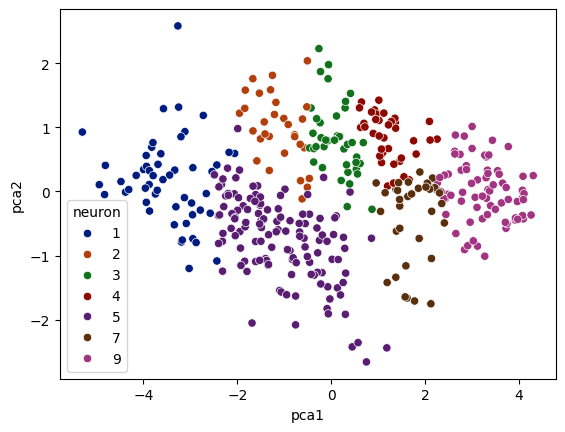

In [211]:
sns.scatterplot(X_pca_with_neuron, x="pca1", y="pca2", hue="neuron", palette="dark")

In [183]:
som.map

,x,y,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,0,0,-0.671989,-0.747545,-0.776218,-0.689537,-0.539142,-0.751010,-0.871343
1,1,0,-0.458140,-0.399036,-0.401385,-0.305171,-0.127848,-0.340008,-0.693251
2,2,0,0.057826,0.004005,-0.005554,0.206035,0.281187,0.132484,-0.458532
3,3,0,0.384809,0.444566,0.388505,0.452659,0.574143,0.503762,0.282967
4,4,0,0.669364,0.674819,0.839208,0.778830,0.786301,0.822347,0.463716
5,0,1,-1.084586,-1.105792,-0.970416,-1.030327,-0.861948,-1.042451,-0.669422
6,1,1,-0.461321,-0.546957,-0.528567,-0.452985,-0.243332,-0.441257,-0.192333
7,2,1,0.149270,-0.010247,-0.035203,0.170936,0.186118,0.044938,0.226094
8,3,1,0.643053,0.597533,0.404557,0.481732,0.389148,0.610576,0.618571
9,4,1,1.084460,1.036522,1.108076,0.978648,0.950074,1.120845,0.780109
